In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import numpy as np
from torch.optim import Adam

In [47]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(2, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
    
class Loupe(nn.Module):
    def __init__(self, image_dims, device):
        super(Loupe, self).__init__()
        self.image_dims = image_dims
        self.device = device

        self.unet = UNet(1)

    def forward(self, x):
        # FFT into k-space
        x = x.view(-1, *self.image_dims, 1)
        undersampled_x = torch.cat((x, torch.zeros(x.shape).to(self.device)), dim=3)
        # undersampled_x = torch.fft(x, signal_ndim=2)

        # Apply probabilistic mask
        # undersampled_x = self.mask(x)

        # iFFT into image space
        # undersampled_x = torch.ifft(undersampled_x, signal_ndim=2)
        # undersampled_x = undersampled_x.to(self.device)

        undersampled_x = undersampled_x.view(-1, 2, *self.image_dims) # Reshape for convolution
        unet_tensor = self.unet(undersampled_x)
        unet_tensor = unet_tensor.view(-1, *self.image_dims, 1) # Reshape for convolution
        # abs_tensor = self.complex_abs(x)
        # add_tensor = unet_tensor + abs_tensor

        return unet_tensor

In [50]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs, batch_size, image_dims, device):
    plt.figure()
    # mask = None
    loss = 0
    loss_list = []
    for epoch in range(num_epochs):
        print('EPOCH', epoch)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

#             metrics = defaultdict(float)
#             metrics['loss'] = 0
#             epoch_samples = 0

            for x, _ in dataloaders[phase]:   
                x = x.view(-1, *image_dims, 1).float().to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    output = model(x)
                    loss = criterion(output, x)
#                     metrics['loss'] += loss.data.cpu().numpy() * x.size(0)

                    if phase == 'train':
                        # print('loss', loss.item())
                        loss.backward()
                        optimizer.step()

        loss_list.append(loss)

#         time_elapsed = time.time() - since
#         print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    # mask_filename = os.path.join(save_dir_loupe, 'mask.npy')
    # np.save(mask_filename, mask.detach().cpu().numpy()) 
    # print('saved mask to', mask_filename)
#     np.savetxt(loss_filename, np.array(loss_list))
#     print('saved loss to', loss_filename)

    return model, loss_list

import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

cuda:0
loading data...
done
unet.dconv_down1.0.weight torch.Size([64, 2, 3, 3])
unet.dconv_down1.0.bias torch.Size([64])
unet.dconv_down1.2.weight torch.Size([64, 64, 3, 3])
unet.dconv_down1.2.bias torch.Size([64])
unet.dconv_down2.0.weight torch.Size([128, 64, 3, 3])
unet.dconv_down2.0.bias torch.Size([128])
unet.dconv_down2.2.weight torch.Size([128, 128, 3, 3])
unet.dconv_down2.2.bias torch.Size([128])
unet.dconv_down3.0.weight torch.Size([256, 128, 3, 3])
unet.dconv_down3.0.bias torch.Size([256])
unet.dconv_down3.2.weight torch.Size([256, 256, 3, 3])
unet.dconv_down3.2.bias torch.Size([256])
unet.dconv_down4.0.weight torch.Size([512, 256, 3, 3])
unet.dconv_down4.0.bias torch.Size([512])
unet.dconv_down4.2.weight torch.Size([512, 512, 3, 3])
unet.dconv_down4.2.bias torch.Size([512])
unet.dconv_up3.0.weight torch.Size([256, 768, 3, 3])
unet.dconv_up3.0.bias torch.Size([256])
unet.dconv_up3.2.weight torch.Size([256, 256, 3, 3])
unet.dconv_up3.2.bias torch.Size([256])
unet.dconv_up2.0.w

/nfs01/shared_software/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
12510
<class 'list'>


<Figure size 432x288 with 0 Axes>

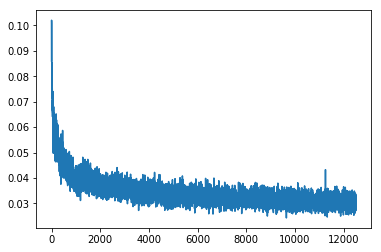

In [55]:
gpu_id = 0
data_path = '/nfs02/users/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32/LOUPE_sel_2D_MRI_SLICE/xdata.npy'

epochs = 10
batch_size = 16

if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpu_id))
else:
    device = torch.device('cpu')
print(device)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

# Data loading
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 8}
# transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()])

# trainset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, **params)
# testset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, **params)

print('loading data...')
xdata = np.load(data_path)
trainset = Dataset(xdata[:int(len(xdata)*0.7)], xdata[:int(len(xdata)*0.7)])
valset = Dataset(xdata[int(len(xdata)*0.7):], xdata[int(len(xdata)*0.7):])
dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, **params),
    'val': torch.utils.data.DataLoader(valset, **params)
}
print('done')

image_dims = xdata.shape[1:-1]

model = Loupe(image_dims, device)
model = model.to(device)

for name, param in model.named_parameters():
    print(name, param.data.size())

criterion = nn.L1Loss()

optimizer = Adam(model.parameters(), lr=0.001)

# loss_filename = os.path.join(save_dir_loupe, 'losses.txt')
model, loss_list = train_model(model, criterion, optimizer, dataloaders, epochs, batch_size, image_dims, device)
print(len(loss_list))
print(type(loss_list))
plt.plot(loss_list)
plt.show()